In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SimPEG.electromagnetics import resistivity as DC
from discretize import TensorMesh
from SimPEG import maps
from SimPEG.electromagnetics.static.resistivity import DCSimulation_1D
from SimPEG.electromagnetics.static.utils import StaticUtils

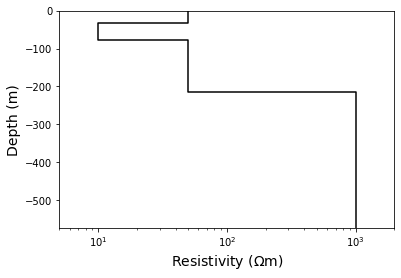

In [2]:
ntx = 11
xtemp_txP = np.logspace(1, np.log10(1000.), ntx)
xtemp_txN = -xtemp_txP
ytemp_tx = np.zeros(ntx)
xtemp_rxP = -5
xtemp_rxN = 5
ytemp_rx = 0. 
abhalf = abs(xtemp_txP-xtemp_txN)*0.5
a = xtemp_rxN-xtemp_rxP
b = ((xtemp_txN-xtemp_txP)-a)*0.5

# We generate tx and rx lists:
srclist = []
for i in range(ntx):
    rx = DC.Rx.Dipole(np.r_[xtemp_rxP, ytemp_rx, -12.5], np.r_[xtemp_rxN, ytemp_rx, -12.5])
    locA = np.r_[xtemp_txP[i], ytemp_tx[i], -12.5]
    locB = np.r_[xtemp_txN[i], ytemp_tx[i], -12.5]
    src = DC.Src.Dipole([rx], locA, locB)
    srclist.append(src)
survey = DC.Survey(srclist)    
dz_min=10.
hz = dz_min * (1.1)**np.arange(20)
mesh_1d = TensorMesh([hz])
inds = np.logical_and(mesh_1d.vectorCCx<80, mesh_1d.vectorCCx>30)
inds_1 = mesh_1d.vectorCCx>200

rho = np.ones(mesh_1d.nC) * 50
rho[inds] = 10.
rho[inds_1] = 1000.
StaticUtils.plot_layer(rho, mesh_1d)

simulation = DCSimulation_1D(
    mesh=mesh_1d, 
    rhoMap=maps.ExpMap(mesh_1d),
    t=hz[:-1],
    survey=survey, 
    data_type='apparent_resistivity'
)

In [3]:
from SimPEG import Data

In [4]:
from SimPEG import (
    maps, data_misfit, regularization,
    optimization, inverse_problem, inversion, directives
)


In [5]:
%%time
dobs = simulation.makeSyntheticData(np.log(rho))

CPU times: user 16.4 ms, sys: 4.94 ms, total: 21.3 ms
Wall time: 46.6 ms


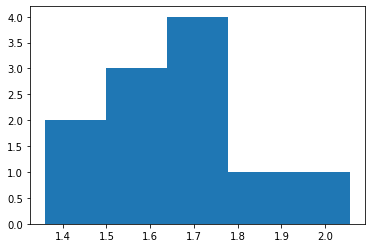

In [6]:
out = plt.hist(np.log10(dobs.dobs), bins=5)
rho0 = 10**out[1][np.argmax(out[0])]

In [7]:
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=dobs)
floor = 0.
std = 0.01
uncert = abs(dobs.dobs) * std + floor
dmis.W = 1./uncert

In [8]:
dobs.dobs.min()

22.936537241269747

In [9]:
dobs.dobs.max()

113.80482312320046

In [10]:
1./mesh_1d.hx.min()**2 * 100.

1.0

In [11]:
regMesh = TensorMesh([mesh_1d.hx])
m0 = np.log(np.ones(rho.size)*20.)
mref = np.log(np.ones(rho.size)*20.)
reg = regularization.Tikhonov(
    regMesh, alpha_s=1./mesh_1d.hx.min()**2 * 1e-2, alpha_x=1.,
    mref=mref, 
    mapping=maps.IdentityMap(mesh=regMesh)
)
opt = optimization.InexactGaussNewton(
    maxIter=30, maxIterCG=20
)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
target = directives.TargetMisfit()
# Create an inversion object
beta = directives.BetaSchedule(coolingFactor=2., coolingRate=1.)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
save =  directives.SaveOutputDictEveryIteration()
inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest, save, target])

opt.remember('xc')
mopt = inv.run(m0)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2019-12-20-14-32.npz'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.83e+04  1.58e+04  0.00e+00  1.58e+04    8.23e+03      0              
   1  1.42e+04  3.32e+03  7.76e-02  4.42e+03    1.20e+04      0              
   2  7.08e+03  5.40e+02  1.15e-01  1.35e+03    1.00e+03      0              
   3  3.54e+03  2.57e+02  1.41e-01  7.57e+02    2.15e+02      0   Skip BFGS  
   4  1.77e+03  1.05e+02  1.73e-01  4.12e+02    1.51e+02      0   Skip BFGS  
   5  8.84e+02  4.01e+01  2.00e-01  2.17e+02    9.60e+01      0   Skip 

(10, 1000)

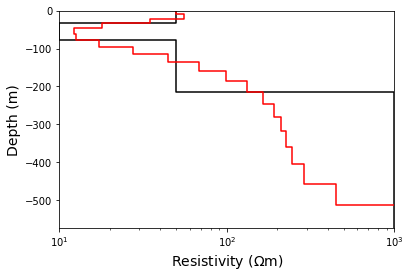

In [12]:
StaticUtils.plot_layer(rho, mesh_1d)
StaticUtils.plot_layer(np.exp(mopt), mesh_1d, **{'color':'r'})
plt.xlim(10, 1000)

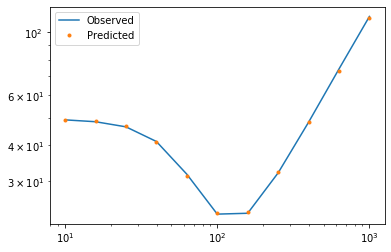

In [13]:
ab = simulation.electrode_separations['AB']
plt.loglog(ab/2., dobs.dobs, '-')
plt.loglog(ab/2., invProb.dpred, '.')
plt.legend(("Observed", "Predicted"))